In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
plt.rcParams["figure.figsize"] = [12, 6]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################
plt.rcParams.update({'axes.grid'     : True})

## Import data

In [123]:
data = pd.read_csv('../data/num_file/min_01/p040.csv')

In [124]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00     23
1       2022-04-21 01:41:00    150
2       2022-04-21 01:42:00     27
3       2022-04-21 01:43:00      0
4       2022-04-21 01:44:00      0
...                     ...    ...
194995  2022-09-03 11:35:00    310
194996  2022-09-03 11:36:00    461
194997  2022-09-03 11:37:00    503
194998  2022-09-03 11:38:00    473
194999  2022-09-03 11:39:00    423

[195000 rows x 2 columns]


If there is no people, use NaN.

In [125]:
data.loc[data['count']==0, 'count'] = np.NaN

In [126]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00   23.0
1       2022-04-21 01:41:00  150.0
2       2022-04-21 01:42:00   27.0
3       2022-04-21 01:43:00    NaN
4       2022-04-21 01:44:00    NaN
...                     ...    ...
194995  2022-09-03 11:35:00  310.0
194996  2022-09-03 11:36:00  461.0
194997  2022-09-03 11:37:00  503.0
194998  2022-09-03 11:38:00  473.0
194999  2022-09-03 11:39:00  423.0

[195000 rows x 2 columns]


<Axes: >

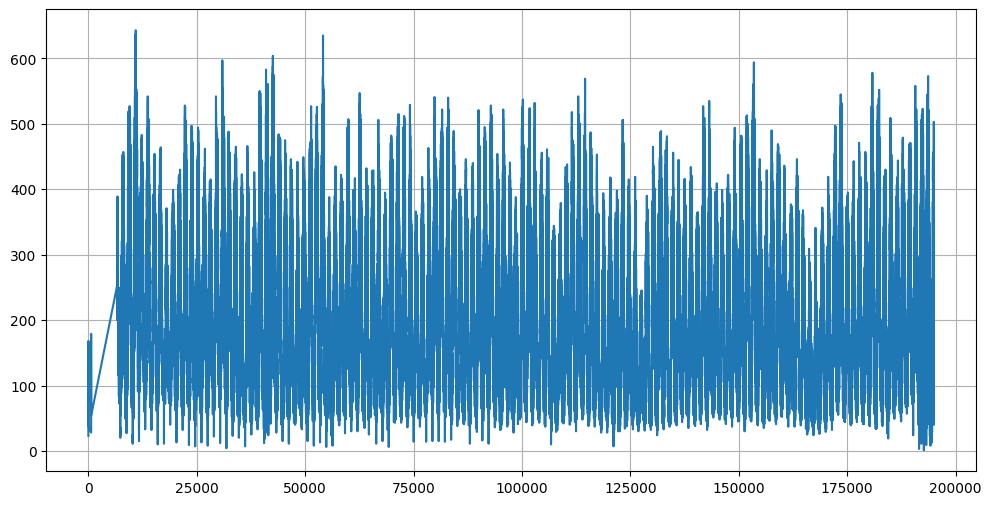

In [127]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

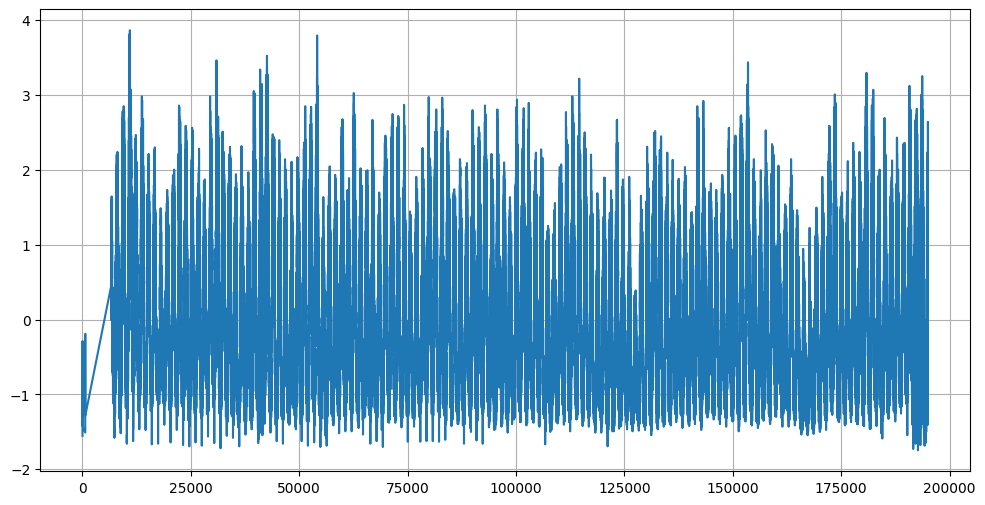

In [128]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [129]:
print(data)

                   datetime     count
0       2022-04-21 01:40:00 -1.554014
1       2022-04-21 01:41:00 -0.443766
2       2022-04-21 01:42:00 -1.519046
3       2022-04-21 01:43:00 -1.476925
4       2022-04-21 01:44:00 -1.434803
...                     ...       ...
194995  2022-09-03 11:35:00  0.954972
194996  2022-09-03 11:36:00  2.275031
194997  2022-09-03 11:37:00  2.642200
194998  2022-09-03 11:38:00  2.379936
194999  2022-09-03 11:39:00  1.942831

[195000 rows x 2 columns]


In [130]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 60

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [131]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [132]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

In [133]:
print(decode_output_data[:, -1, :])

[[-1.42787379]
 [-1.4280164 ]
 [-1.42815901]
 ...
 [ 2.27503087]
 [ 2.64219956]
 [ 2.37993621]]


## Model

In [134]:
from keras.layers import Input, LSTM, BatchNormalization, TimeDistributed, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [135]:
input_data = Input(shape=(time_step, 1))
x = LSTM(32, return_sequences=True)(input_data)
x = BatchNormalization()(x)
output_data = TimeDistributed(Dense(1))(x)

In [136]:
model = Model(inputs=input_data, outputs=output_data)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 32)            4352      
                                                                 
 batch_normalization_5 (Batc  (None, 60, 32)           128       
 hNormalization)                                                 
                                                                 
 time_distributed_5 (TimeDis  (None, 60, 1)            33        
 tributed)                                                       
                                                                 
Total params: 4,513
Trainable params: 4,449
Non-trainable params: 64
_________________________________________________________________


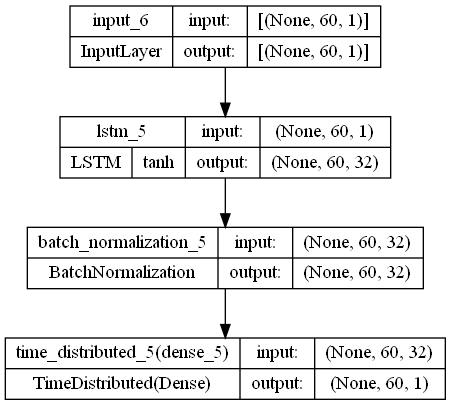

In [137]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_activations=True)

In [138]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es])

Epoch 1/100
1097/1097 [==============================] - 8s 5ms/step - loss: 0.0632 - mae: 0.1764 - val_loss: 0.0633 - val_mae: 0.1823
Epoch 2/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0519 - mae: 0.1633 - val_loss: 0.0516 - val_mae: 0.1652
Epoch 3/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0487 - mae: 0.1565 - val_loss: 0.0440 - val_mae: 0.1423
Epoch 4/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0486 - mae: 0.1568 - val_loss: 0.0441 - val_mae: 0.1434
Epoch 5/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0487 - mae: 0.1573 - val_loss: 0.0438 - val_mae: 0.1420
Epoch 6/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0485 - mae: 0.1580 - val_loss: 0.0417 - val_mae: 0.1391
Epoch 7/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0471 - mae: 0.1555 - val_loss: 0.0411 - val_mae: 0.1383
Epoch 8/100
1097/1097 [==============================] 

KeyboardInterrupt: 

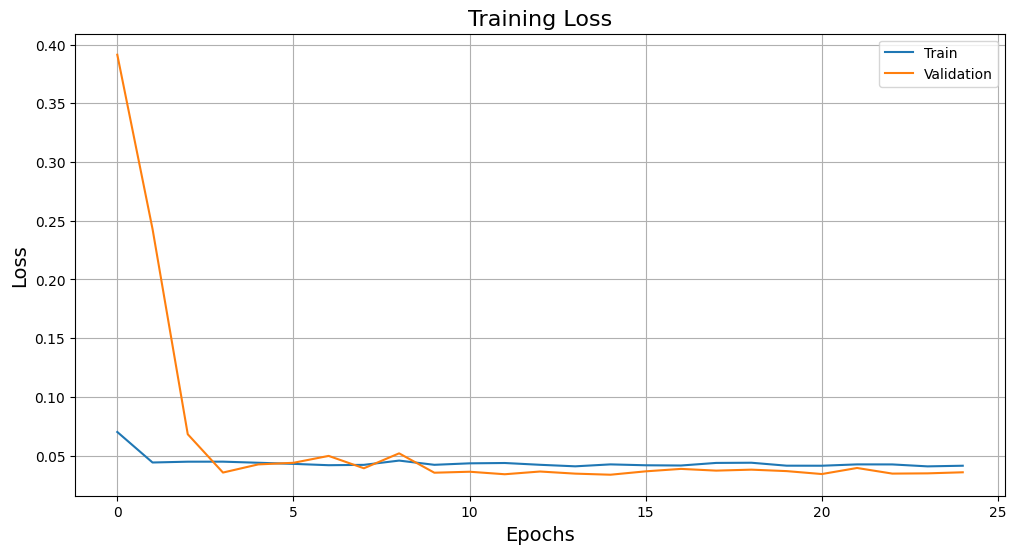

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
predict_test = model.predict(encode_input_data_test)

244/244 [==============================] - 0s 1ms/step


In [ ]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

In [ ]:
print(predict_test_data)

[[ 697.63837]
 [ 787.3285 ]
 [ 724.8534 ]
 ...
 [1138.0946 ]
 [1738.8572 ]
 [1730.8611 ]]


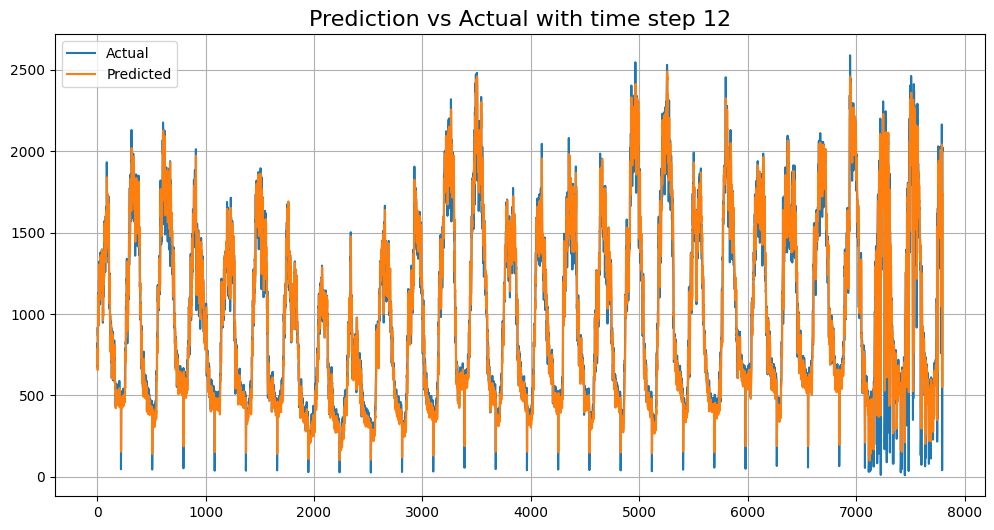

In [ ]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.legend(['Actual', 'Predicted'])
plt.title(f'Prediction vs Actual with time step {time_step}')
plt.show()

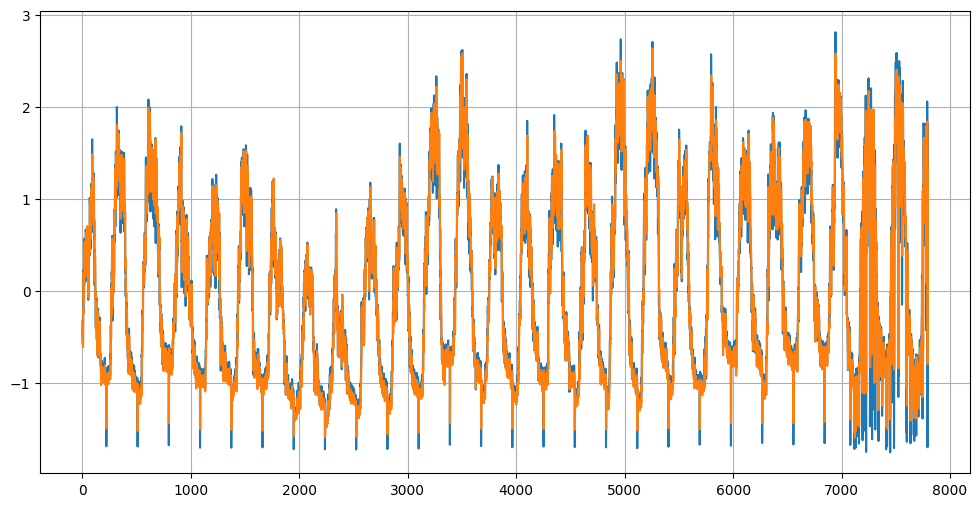

In [ ]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

In [ ]:
print(predict_test_data)

[[ 697.63837]
 [ 787.3285 ]
 [ 724.8534 ]
 ...
 [1138.0946 ]
 [1738.8572 ]
 [1730.8611 ]]


In [ ]:
print(decode_output_test_data)

[[ 818.]
 [ 735.]
 [ 770.]
 ...
 [1913.]
 [2024.]
 [2006.]]


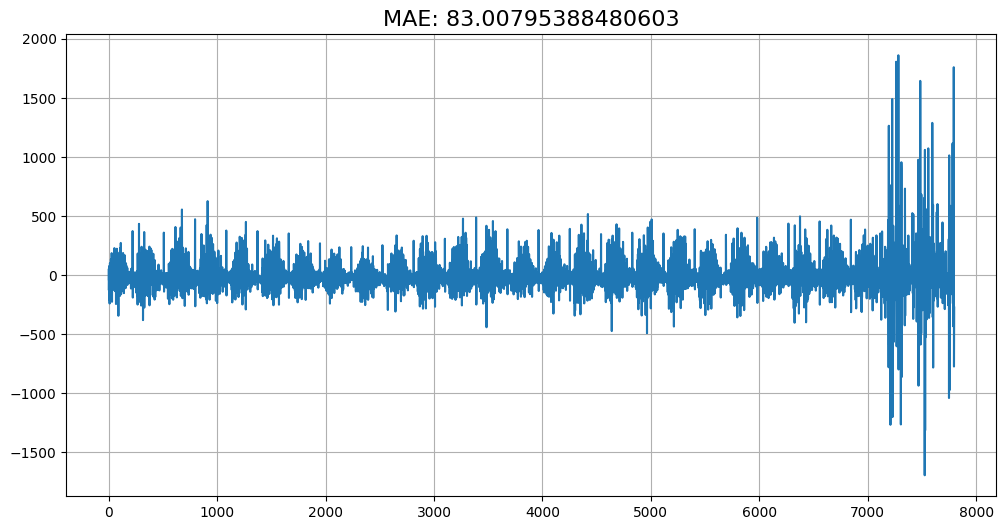

In [ ]:
from sklearn.metrics import mean_absolute_error
plt.title('MAE: {}'.format(mean_absolute_error(decode_output_test_data, predict_test_data)))
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

83.00795388480603
